In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, Activation, LeakyReLU, LSTM
from keras import backend
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn import svm
from scipy.stats import norm
from scipy.optimize import brentq
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_excel('optionsdata.xlsx', index_col=0)
data

,TimeStamp,Last,LastSize,TotalVolume,Bid,Ask,TickID,BidSize,AskSize,BasisForLast,...,DaysToExpire,OptionStrike,InterestRate,StockLast,StockBid,StockAsk,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value
0,2012-10-05-09:30:02,101.15,1,1,99.25,101.15,41080,0,0,C,...,43,570,0.2855,665.000,665.02,665.67,0.116724,0.000587,0.393474,100.200003
1,2012-10-05-11:23:58,95.15,9,10,93.60,95.15,102817472,0,0,C,...,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007
2,2012-10-05-11:23:58,95.15,9,19,93.60,95.15,102817505,0,0,C,...,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007
3,2012-10-05-12:09:51,89.28,7,26,88.95,89.75,135660543,0,0,C,...,43,570,0.2855,652.800,652.80,652.88,0.116420,0.000587,0.390176,89.350000
4,2012-10-05-12:09:52,89.29,3,29,89.00,89.55,135679625,0,0,C,...,43,570,0.2855,653.010,652.81,652.83,0.116420,0.000587,0.384934,89.275000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189907,2012-10-03-15:16:21,207.59,7,33,207.00,208.15,227968116,0,0,C,...,836,760,0.9590,668.209,668.10,668.21,2.288668,0.001146,0.374034,207.575000
189908,2012-10-03-09:41:43,215.00,7,7,215.00,215.70,17117842,0,0,C,...,836,770,0.9590,665.630,665.52,665.65,2.289304,0.001146,0.372895,215.350000
189909,2012-10-03-10:03:27,217.00,10,17,216.50,219.00,42206214,0,0,C,...,836,770,0.9590,663.280,663.13,663.28,2.289263,0.001146,0.376018,217.749986
189910,2012-10-03-13:27:36,214.35,9,26,213.20,215.50,172153820,0,0,C,...,836,770,0.9590,667.975,667.88,667.98,2.288874,0.001146,0.373284,214.350050


In [4]:
data = data.drop(['TimeStamp', 'LastSize', 'TotalVolume', 'TickID', 'BasisForLast', 'Option', 'Position', 'ExpirationDate'], axis=1)
data

,Last,Bid,Ask,BidSize,AskSize,OptionType,DaysToExpire,OptionStrike,InterestRate,StockLast,StockBid,StockAsk,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value
0,101.15,99.25,101.15,0,0,C,43,570,0.2855,665.000,665.02,665.67,0.116724,0.000587,0.393474,100.200003
1,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007
2,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007
3,89.28,88.95,89.75,0,0,C,43,570,0.2855,652.800,652.80,652.88,0.116420,0.000587,0.390176,89.350000
4,89.29,89.00,89.55,0,0,C,43,570,0.2855,653.010,652.81,652.83,0.116420,0.000587,0.384934,89.275000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189907,207.59,207.00,208.15,0,0,P,836,760,0.9590,668.209,668.10,668.21,2.288668,0.001146,0.374034,207.575000
189908,215.00,215.00,215.70,0,0,P,836,770,0.9590,665.630,665.52,665.65,2.289304,0.001146,0.372895,215.350000
189909,217.00,216.50,219.00,0,0,P,836,770,0.9590,663.280,663.13,663.28,2.289263,0.001146,0.376018,217.749986
189910,214.35,213.20,215.50,0,0,P,836,770,0.9590,667.975,667.88,667.98,2.288874,0.001146,0.373284,214.350050


In [5]:
data.isnull().values.any()

True

In [6]:
data = data.dropna()

In [7]:
data.isnull().values.any()

False

In [8]:
from math import log, sqrt, exp, pi
from scipy.stats import norm

def Kc(X, T, r, b, v):
    # Calculation of seed value, Si
    N = 2 * b / (v**2)
    m = 2 * r / (v**2)
    q2u = (-(N - 1) + math.sqrt((N - 1)**2 + 4 * m)) / 2
    su = X / (1 - 1 / q2u)
    h2 = -(b * T + 2 * v * math.sqrt(T)) * X / (su - X)
    Si = X + (su - X) * (1 - math.exp(h2))

    K = 2 * r / (v**2 * (1 - math.exp(-r * T)))
    d1 = (math.log(Si / X) + (b + v**2 / 2) * T) / (v * math.sqrt(T))
    Q2 = (-(N - 1) + math.sqrt((N - 1)**2 + 4 * K)) / 2
    LHS = Si - X
    RHS = GBlackScholes("c", Si, X, T, r, b, v) + (1 - math.exp((b - r) * T) * norm.cdf(d1)) * Si / Q2
    bi = math.exp((b - r) * T) * norm.cdf(d1) * (1 - 1 / Q2) + (1 - math.exp((b - r) * T) * norm.cdf(d1) / (v * math.sqrt(T))) / Q2
    E = 1e-06

    # Newton Raphson algorithm for finding critical price Si
    while abs(LHS - RHS) / X > E:
        Si = (X + RHS - bi * Si) / (1 - bi)
        d1 = (math.log(Si / X) + (b + v**2 / 2) * T) / (v * math.sqrt(T))
        LHS = Si - X
        RHS = GBlackScholes("C", Si, X, T, r, b, v) + (1 - math.exp((b - r) * T) * norm.cdf(d1)) * Si / Q2
        bi = math.exp((b - r) * T) * norm.cdf(d1) * (1 - 1 / Q2) + (1 - math.exp((b - r) * T) * norm.cdf(d1) / (v * math.sqrt(T))) / Q2

    return Si

In [9]:
def BAWAmericanCallApprox(CallPutFlag, S, X, T, r, b, v):
    if CallPutFlag == 'C':
        if b >= r:
            return GBlackScholes("C", S, X, T, r, b, v)
        else:
            Sk = Kc(X, T, r, b, v)
            N = 2 * b / v**2
            K = 2 * r / (v**2 * (1 - math.exp(-r * T)))
            d1 = (math.log(Sk / X) + (b + v**2 / 2) * T) / (v * math.sqrt(T))
            Q2 = (-(N - 1) + math.sqrt((N - 1)**2 + 4 * K)) / 2
            a2 = (Sk / Q2) * (1 - math.exp((b - r) * T) * norm.cdf(d1))
            if S < Sk:
                return GBlackScholes("C", S, X, T, r, b, v) - a2 * (S / Sk)**Q2
            else:
                return S - X
    else:
        GBlackScholes('P', S, X, T, r, b, v)

In [10]:
price = 0
def GBlackScholes(CallPutFlag, S, X, T, r, b, v):
    d1 = (log(S / X) + (b + v**2 / 2) * T) / (v * sqrt(T))
    d2 = d1 - v * sqrt(T)

    if CallPutFlag == "C":
        global price
        price = S * exp((b - r) * T) * norm.cdf(d1) - X * exp(-r * T) * norm.cdf(d2)
    elif CallPutFlag == "P":
        price = X * exp(-r * T) * norm.cdf(-d2) - S * exp((b - r) * T) * norm.cdf(-d1)
    return price

In [11]:
import math

def CRRBinomial(CallPutFlag, S, X, T, r, b, v, n):
    OptionValue = [0] * (n + 1)
    if CallPutFlag == "C":
        z = 1
    elif CallPutFlag == "P":
        z = -1
    dt = T / n
    u = math.exp(v * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(b * dt) - d) / (u - d)
    Df = math.exp(-r * dt)
    for i in range(n+1):
        OptionValue[i] = max(0, z * (S * u ** i * d ** (n - i) - X))
    for j in range(n-1, -1, -1):
        for i in range(j+1):
            OptionValue[i] = (p * OptionValue[i+1] + (1 - p) * OptionValue[i]) * Df
        if j == 2:
            ReturnValue = [0] * 4
            ReturnValue[2] = ((OptionValue[2] - OptionValue[1]) / (S * u ** 2 - S) - (OptionValue[1] - OptionValue[0]) / (S - S * d ** 2)) / (0.5 * (S * u ** 2 - S * d ** 2))
            ReturnValue[3] = OptionValue[1]
        if j == 1:
            ReturnValue[1] = (OptionValue[1] - OptionValue[0]) / (S * u - S * d)
    return OptionValue[0]

In [12]:
def BTOption(x):
#     option_type = x['OptionType']
#     S = x['StockLast']
#     X = x['OptionStrike']
#     r = x['Risk_free_Rate']
#     b = 0
#     T = x['Years_to_Expiry']
#     v = x['Imp_Vol']
    return CRRBinomial(x['OptionType'], x['StockLast'], x['OptionStrike'], x['Years_to_Expiry'], x['Risk_free_Rate'], 0, x['Imp_Vol'], 5)

In [13]:
def BSOption(x):
#     option_type = x['OptionType']
#     S = x['StockLast']
#     X = x['OptionStrike']
#     r = x['Risk_free_Rate']
#     b = 0
#     T = x['Years_to_Expiry']
#     v = x['Imp_Vol']
    return CRRBinomial(x['OptionType'], x['StockLast'], x['OptionStrike'], x['Years_to_Expiry'], x['Risk_free_Rate'], 0, x['Imp_Vol'], 5)

In [14]:
data['BT_Option_Price'] = data.apply(BTOption, axis=1)
data['BS_Option_Price'] = data.apply(BSOption, axis=1)
data

C:\Users\syune.gevorgyan.a\AppData\Local\Temp\ipykernel_7516\20046565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BT_Option_Price'] = data.apply(BTOption, axis=1)
C:\Users\syune.gevorgyan.a\AppData\Local\Temp\ipykernel_7516\20046565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BS_Option_Price'] = data.apply(BSOption, axis=1)


,Last,Bid,Ask,BidSize,AskSize,OptionType,DaysToExpire,OptionStrike,InterestRate,StockLast,StockBid,StockAsk,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value,BT_Option_Price,BS_Option_Price
0,101.15,99.25,101.15,0,0,C,43,570,0.2855,665.000,665.02,665.67,0.116724,0.000587,0.393474,100.200003,100.322131,100.322131
1,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193
2,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193
3,89.28,88.95,89.75,0,0,C,43,570,0.2855,652.800,652.80,652.88,0.116420,0.000587,0.390176,89.350000,89.966989,89.966989
4,89.29,89.00,89.55,0,0,C,43,570,0.2855,653.010,652.81,652.83,0.116420,0.000587,0.384934,89.275000,89.837183,89.837183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189907,207.59,207.00,208.15,0,0,P,836,760,0.9590,668.209,668.10,668.21,2.288668,0.001146,0.374034,207.575000,212.083658,212.083658
189908,215.00,215.00,215.70,0,0,P,836,770,0.9590,665.630,665.52,665.65,2.289304,0.001146,0.372895,215.350000,218.749876,218.749876
189909,217.00,216.50,219.00,0,0,P,836,770,0.9590,663.280,663.13,663.28,2.289263,0.001146,0.376018,217.749986,220.997333,220.997333
189910,214.35,213.20,215.50,0,0,P,836,770,0.9590,667.975,667.88,667.98,2.288874,0.001146,0.373284,214.350050,218.006368,218.006368


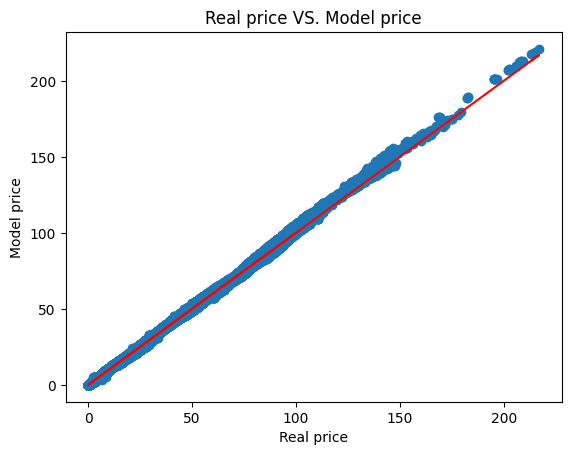

In [27]:
x = data['Last']
y = data['BT_Option_Price']
plt.scatter(x, y)
plt.plot(x, x, 'r-')
plt.title('Real price VS. Model price')
plt.xlabel('Real price')
plt.ylabel('Model price')
plt.show()

In [28]:
print('MSE of Binomial Tree method: ',((data['BT_Option_Price'] - data['Last']) ** 2).mean())

MSE of Binomial Tree method:  1.0157108096636123


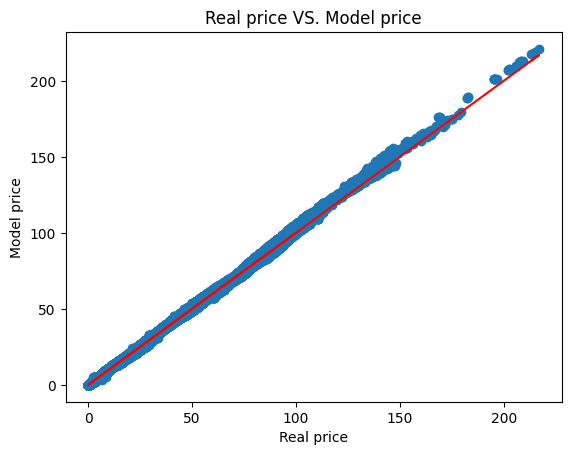

In [407]:
x = data['Last']
y = data['BS_Option_Price']
plt.scatter(x, y)
plt.plot(x, x, 'r-')
plt.title('Real price VS. Model price')
plt.xlabel('Real price')
plt.ylabel('Model price')
plt.show()

In [29]:
print('MSE of Black Scholes method: ', ((data['BS_Option_Price'] - data['Last']) ** 2).mean())

MSE of Black Scholes method:  1.0157108096636123


In [30]:
data['OptionType_C'] = (data['OptionType'] == 'C').astype(int)
data['OptionType_P'] = (data['OptionType'] == 'P').astype(int)
# data.drop('OptionType')

C:\Users\syune.gevorgyan.a\AppData\Local\Temp\ipykernel_7516\1394352087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OptionType_C'] = (data['OptionType'] == 'C').astype(int)
C:\Users\syune.gevorgyan.a\AppData\Local\Temp\ipykernel_7516\1394352087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OptionType_P'] = (data['OptionType'] == 'P').astype(int)


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189838 entries, 0 to 189911
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Last             189838 non-null  float64
 1   Bid              189838 non-null  float64
 2   Ask              189838 non-null  float64
 3   BidSize          189838 non-null  int64  
 4   AskSize          189838 non-null  int64  
 5   OptionType       189838 non-null  object 
 6   DaysToExpire     189838 non-null  int64  
 7   OptionStrike     189838 non-null  int64  
 8   InterestRate     189838 non-null  float64
 9   StockLast        189838 non-null  float64
 10  StockBid         189838 non-null  float64
 11  StockAsk         189838 non-null  float64
 12  Years_to_Expiry  189838 non-null  float64
 13  Risk_free_Rate   189838 non-null  float64
 14  Imp_Vol          189838 non-null  float64
 15  Option_Value     189838 non-null  float64
 16  BT_Option_Price  189838 non-null  float64
 

In [32]:
data.drop_duplicates('Option_Value', keep='last')
data

,Last,Bid,Ask,BidSize,AskSize,OptionType,DaysToExpire,OptionStrike,InterestRate,StockLast,StockBid,StockAsk,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value,BT_Option_Price,BS_Option_Price,OptionType_C,OptionType_P
0,101.15,99.25,101.15,0,0,C,43,570,0.2855,665.000,665.02,665.67,0.116724,0.000587,0.393474,100.200003,100.322131,100.322131,1,0
1,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193,1,0
2,95.15,93.60,95.15,0,0,C,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193,1,0
3,89.28,88.95,89.75,0,0,C,43,570,0.2855,652.800,652.80,652.88,0.116420,0.000587,0.390176,89.350000,89.966989,89.966989,1,0
4,89.29,89.00,89.55,0,0,C,43,570,0.2855,653.010,652.81,652.83,0.116420,0.000587,0.384934,89.275000,89.837183,89.837183,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189907,207.59,207.00,208.15,0,0,P,836,760,0.9590,668.209,668.10,668.21,2.288668,0.001146,0.374034,207.575000,212.083658,212.083658,0,1
189908,215.00,215.00,215.70,0,0,P,836,770,0.9590,665.630,665.52,665.65,2.289304,0.001146,0.372895,215.350000,218.749876,218.749876,0,1
189909,217.00,216.50,219.00,0,0,P,836,770,0.9590,663.280,663.13,663.28,2.289263,0.001146,0.376018,217.749986,220.997333,220.997333,0,1
189910,214.35,213.20,215.50,0,0,P,836,770,0.9590,667.975,667.88,667.98,2.288874,0.001146,0.373284,214.350050,218.006368,218.006368,0,1


In [91]:
data1 = data.copy()
data1 = data1.drop('OptionType', axis=1)
# data1 = data.sample(frac=0.50)
data1

,Last,Bid,Ask,BidSize,AskSize,DaysToExpire,OptionStrike,InterestRate,StockLast,StockBid,StockAsk,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value,BT_Option_Price,BS_Option_Price,OptionType_C,OptionType_P
0,101.15,99.25,101.15,0,0,43,570,0.2855,665.000,665.02,665.67,0.116724,0.000587,0.393474,100.200003,100.322131,100.322131,1,0
1,95.15,93.60,95.15,0,0,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193,1,0
2,95.15,93.60,95.15,0,0,43,570,0.2855,659.960,659.90,659.96,0.116507,0.000587,0.362276,94.375007,94.293193,94.293193,1,0
3,89.28,88.95,89.75,0,0,43,570,0.2855,652.800,652.80,652.88,0.116420,0.000587,0.390176,89.350000,89.966989,89.966989,1,0
4,89.29,89.00,89.55,0,0,43,570,0.2855,653.010,652.81,652.83,0.116420,0.000587,0.384934,89.275000,89.837183,89.837183,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189907,207.59,207.00,208.15,0,0,836,760,0.9590,668.209,668.10,668.21,2.288668,0.001146,0.374034,207.575000,212.083658,212.083658,0,1
189908,215.00,215.00,215.70,0,0,836,770,0.9590,665.630,665.52,665.65,2.289304,0.001146,0.372895,215.350000,218.749876,218.749876,0,1
189909,217.00,216.50,219.00,0,0,836,770,0.9590,663.280,663.13,663.28,2.289263,0.001146,0.376018,217.749986,220.997333,220.997333,0,1
189910,214.35,213.20,215.50,0,0,836,770,0.9590,667.975,667.88,667.98,2.288874,0.001146,0.373284,214.350050,218.006368,218.006368,0,1


In [92]:
data1 = data1[['OptionType_C', 'OptionType_P', 'OptionStrike', 'InterestRate', 'StockLast', 'Years_to_Expiry', 'Risk_free_Rate', 'Imp_Vol', 'Option_Value']]
data1

,OptionType_C,OptionType_P,OptionStrike,InterestRate,StockLast,Years_to_Expiry,Risk_free_Rate,Imp_Vol,Option_Value
0,1,0,570,0.2855,665.000,0.116724,0.000587,0.393474,100.200003
1,1,0,570,0.2855,659.960,0.116507,0.000587,0.362276,94.375007
2,1,0,570,0.2855,659.960,0.116507,0.000587,0.362276,94.375007
3,1,0,570,0.2855,652.800,0.116420,0.000587,0.390176,89.350000
4,1,0,570,0.2855,653.010,0.116420,0.000587,0.384934,89.275000
...,...,...,...,...,...,...,...,...,...
189907,0,1,760,0.9590,668.209,2.288668,0.001146,0.374034,207.575000
189908,0,1,770,0.9590,665.630,2.289304,0.001146,0.372895,215.350000
189909,0,1,770,0.9590,663.280,2.289263,0.001146,0.376018,217.749986
189910,0,1,770,0.9590,667.975,2.288874,0.001146,0.373284,214.350050


In [93]:
# data1 = data1.drop_duplicates()
# data1

In [94]:
# column names
colname = data1.columns.values
print('Input Varaibles: ')
print(data1.columns.values[:-1])
print("Output Variable: ")
print(data1.columns.values[-1])

data1 = np.array(data1)
np.random.shuffle(data1)


Input Varaibles: 
['OptionType_C' 'OptionType_P' 'OptionStrike' 'InterestRate' 'StockLast'
 'Years_to_Expiry' 'Risk_free_Rate' 'Imp_Vol']
Output Variable: 
Option_Value


Train Test Split

In [95]:
x = data1[:, :-1]
y = data1[:, -1].reshape(-1,1)

In [96]:
x = (x-np.mean(x,axis=0)) / np.std(x, axis=0)

In [97]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [98]:
test_ratio = 0.2
num_test = int(test_ratio*data1.shape[0])
x_test = x[:num_test]
x_train = x[num_test:]
y_test = y[:num_test]
y_train = y[num_test:]

In [99]:
x_train.shape

(151871, 8)

In [111]:
model1 = Sequential()

model1.add(Dense(64, input_shape = [8],activation = 'relu'))
model1.add(Dropout(0.25))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(1))
          
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                576       
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                1040      
                                                                 
 dropout_36 (Dropout)        (None, 16)                0         
                                                                 
 dense_55 (Dense)            (None, 1)               

In [112]:
history = model1.fit(x=x_train, y=y_train, epochs=250, batch_size=128, validation_split=0.2, verbose=1, shuffle=True, )


Epoch 1/250
950/950 [==============================] - 2s 1ms/step - loss: 137.4020 - val_loss: 9.0886
Epoch 2/250
950/950 [==============================] - 1s 1ms/step - loss: 55.2501 - val_loss: 6.2776
Epoch 3/250
950/950 [==============================] - 1s 1ms/step - loss: 52.2542 - val_loss: 2.9406
Epoch 4/250
950/950 [==============================] - 1s 1ms/step - loss: 48.0436 - val_loss: 5.8533
Epoch 5/250
950/950 [==============================] - 1s 1ms/step - loss: 46.8857 - val_loss: 2.1032
Epoch 6/250
950/950 [==============================] - 1s 1ms/step - loss: 43.6896 - val_loss: 2.8007
Epoch 7/250
950/950 [==============================] - 1s 1ms/step - loss: 41.7941 - val_loss: 4.0422
Epoch 8/250
950/950 [==============================] - 1s 1ms/step - loss: 39.4251 - val_loss: 13.5691
Epoch 9/250
950/950 [==============================] - 1s 1ms/step - loss: 37.4742 - val_loss: 3.5909
Epoch 10/250
950/950 [==============================] - 1s 1ms/step - loss: 36.2

950/950 [==============================] - 1s 1ms/step - loss: 22.2102 - val_loss: 8.4361
Epoch 81/250
950/950 [==============================] - 1s 1ms/step - loss: 21.8214 - val_loss: 6.8183
Epoch 82/250
950/950 [==============================] - 1s 1ms/step - loss: 21.8801 - val_loss: 8.7736
Epoch 83/250
950/950 [==============================] - 1s 1ms/step - loss: 22.1293 - val_loss: 8.3229
Epoch 84/250
950/950 [==============================] - 1s 1ms/step - loss: 22.4160 - val_loss: 11.4174
Epoch 85/250
950/950 [==============================] - 1s 1ms/step - loss: 21.5451 - val_loss: 13.9467
Epoch 86/250
950/950 [==============================] - 1s 1ms/step - loss: 21.9574 - val_loss: 10.1659
Epoch 87/250
950/950 [==============================] - 1s 1ms/step - loss: 22.1695 - val_loss: 9.6106
Epoch 88/250
950/950 [==============================] - 1s 1ms/step - loss: 21.7539 - val_loss: 9.8033
Epoch 89/250
950/950 [==============================] - 1s 1ms/step - loss: 21.9414

Epoch 159/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4751 - val_loss: 11.0789
Epoch 160/250
950/950 [==============================] - 1s 1ms/step - loss: 21.2092 - val_loss: 9.9622
Epoch 161/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4366 - val_loss: 14.4011
Epoch 162/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4374 - val_loss: 19.2242
Epoch 163/250
950/950 [==============================] - 1s 1ms/step - loss: 21.2869 - val_loss: 9.2836
Epoch 164/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4649 - val_loss: 9.0979
Epoch 165/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4386 - val_loss: 9.8884
Epoch 166/250
950/950 [==============================] - 1s 1ms/step - loss: 21.4131 - val_loss: 11.6911
Epoch 167/250
950/950 [==============================] - 1s 1ms/step - loss: 21.0088 - val_loss: 8.7891
Epoch 168/250
950/950 [==============================] - 1s 

950/950 [==============================] - 1s 1ms/step - loss: 20.6630 - val_loss: 11.9042
Epoch 238/250
950/950 [==============================] - 1s 1ms/step - loss: 21.0252 - val_loss: 12.5906
Epoch 239/250
950/950 [==============================] - 1s 1ms/step - loss: 21.1636 - val_loss: 9.8638
Epoch 240/250
950/950 [==============================] - 1s 1ms/step - loss: 21.0204 - val_loss: 9.6663
Epoch 241/250
950/950 [==============================] - 1s 1ms/step - loss: 21.1898 - val_loss: 12.1579
Epoch 242/250
950/950 [==============================] - 1s 1ms/step - loss: 20.8485 - val_loss: 9.3288
Epoch 243/250
950/950 [==============================] - 1s 1ms/step - loss: 21.2839 - val_loss: 11.0244
Epoch 244/250
950/950 [==============================] - 1s 1ms/step - loss: 21.0522 - val_loss: 10.0384
Epoch 245/250
950/950 [==============================] - 1s 1ms/step - loss: 21.3219 - val_loss: 10.5385
Epoch 246/250
950/950 [==============================] - 1s 1ms/step - l

Train and cross validation mean squared error

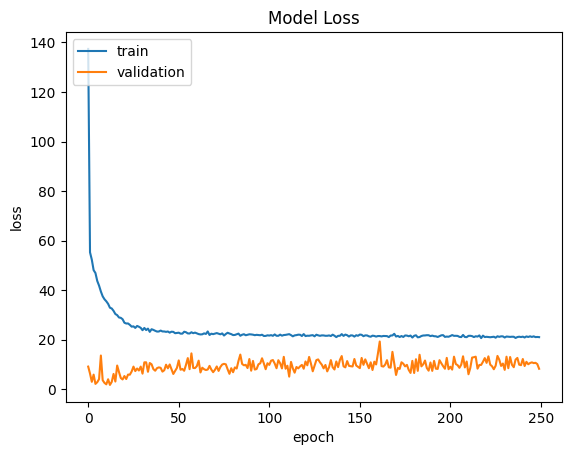

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

Evaluate test set

In [114]:
predicted = model1.predict(x_test)

1187/1187 [==============================] - 1s 492us/step


In [115]:
loss = model1.evaluate(x_test,y_test)
loss

1187/1187 [==============================] - 1s 539us/step - loss: 8.0813


8.081338882446289

In [116]:
def f(x):
    return x

a = y_test.flatten()
b = predicted.flatten()
a = list(a)
b = list(b)

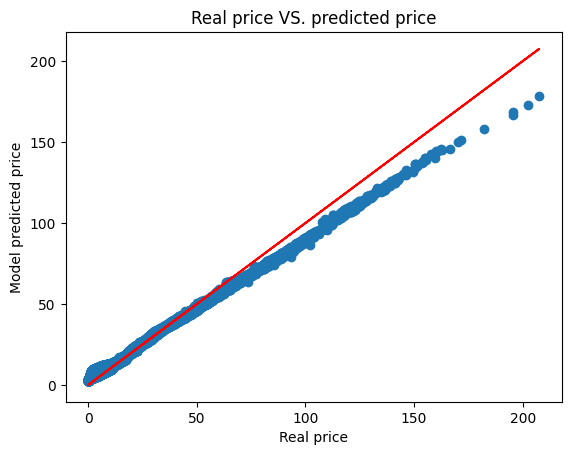

In [117]:
plt.scatter(a, b)
plt.plot(a, f(a),'r-')
plt.title('Real price VS. predicted price')
plt.xlabel('Real price')
plt.ylabel('Model predicted price')
plt.show()

In [118]:
diff = {}
for i,pred in enumerate(predicted):
    diff[i]=abs(pred-y_test[i])
diff = zip(diff.values(),diff.keys())
top10 = sorted(diff)[:20]
for item in top10:
    ind = item[1]
    print("Real Market Price is: {}".format(y_test[ind]))
    print("Model Predicted Price is: {}".format(predicted[ind]))
    print("\n")

Real Market Price is: [8.375]
Model Predicted Price is: [8.374992]


Real Market Price is: [26.40000572]
Model Predicted Price is: [26.399921]


Real Market Price is: [14.52499914]
Model Predicted Price is: [14.525101]


Real Market Price is: [7.97500164]
Model Predicted Price is: [7.975107]


Real Market Price is: [17.97500013]
Model Predicted Price is: [17.974796]


Real Market Price is: [17.97500013]
Model Predicted Price is: [17.974796]


Real Market Price is: [11.62500024]
Model Predicted Price is: [11.62479]


Real Market Price is: [11.62500024]
Model Predicted Price is: [11.62479]


Real Market Price is: [16.42499999]
Model Predicted Price is: [16.425266]


Real Market Price is: [31.42499039]
Model Predicted Price is: [31.425287]


Real Market Price is: [16.1]
Model Predicted Price is: [16.100458]


Real Market Price is: [37.22499903]
Model Predicted Price is: [37.22548]


Real Market Price is: [16.97500002]
Model Predicted Price is: [16.975557]


Real Market Price is: [8.625000

In [119]:
diff = {}
for i,pred in enumerate(predicted):
    diff[i]=abs(pred-y_test[i])
diff = zip(diff.values(),diff.keys())
worst10 = sorted(diff,reverse=True)[:10]
print("Worst 10 matches\n")
for item in worst10:
    ind = item[1]
    print("Real Market Price is: {}".format(y_test[ind]))
    print("Model Predicted Price is: {}\n".format(predicted[ind]))

Worst 10 matches

Real Market Price is: [202.47499999]
Model Predicted Price is: [172.91632]

Real Market Price is: [207.575]
Model Predicted Price is: [178.51477]

Real Market Price is: [195.42499999]
Model Predicted Price is: [166.87173]

Real Market Price is: [195.47499999]
Model Predicted Price is: [168.6412]

Real Market Price is: [182.04999999]
Model Predicted Price is: [157.83377]

Real Market Price is: [171.85002816]
Model Predicted Price is: [151.37062]

Real Market Price is: [166.37501563]
Model Predicted Price is: [145.984]

Real Market Price is: [170.22502639]
Model Predicted Price is: [150.18103]

Real Market Price is: [159.67500622]
Model Predicted Price is: [140.10423]

Real Market Price is: [149.42499967]
Model Predicted Price is: [131.35156]



# Let's try to write model only on call options

In [338]:
data2 = data[data['OptionType'] == 'C']
data2 = data2.drop(['OptionType', 'BidSize', 'AskSize', 'Years_to_Expiry', 'Option_Value', 'BS_Option_Price', 'StockBid', 'StockAsk', 'Bid', 'Ask', 'OptionType_C', 'OptionType_P'], axis=1)
data2 = data2[data2.BT_Option_Price != 0]
data2

,Last,DaysToExpire,OptionStrike,InterestRate,StockLast,Risk_free_Rate,Imp_Vol,BT_Option_Price
0,101.15,43,570,0.2855,665.00,0.000587,0.393474,100.322131
1,95.15,43,570,0.2855,659.96,0.000587,0.362276,94.293193
2,95.15,43,570,0.2855,659.96,0.000587,0.362276,94.293193
3,89.28,43,570,0.2855,652.80,0.000587,0.390176,89.966989
4,89.29,43,570,0.2855,653.01,0.000587,0.384934,89.837183
...,...,...,...,...,...,...,...,...
189873,127.70,836,700,0.9590,671.50,0.001146,0.343327,132.743605
189874,127.41,836,700,0.9590,671.50,0.001146,0.343327,132.743605
189875,106.00,836,750,0.9590,664.71,0.001146,0.340069,107.674004
189876,106.25,836,750,0.9590,663.93,0.001146,0.342436,108.219587


In [339]:
# column names
colname = data2.columns.values
print('Input Varaibles: ')
print(data2.columns.values[:-1])
print("Output Variable: ")
print(data2.columns.values[-1])

data2 = np.array(data2)
np.random.shuffle(data2)


Input Varaibles: 
['Last' 'DaysToExpire' 'OptionStrike' 'InterestRate' 'StockLast'
 'Risk_free_Rate' 'Imp_Vol']
Output Variable: 
BT_Option_Price


In [340]:
x = data2[:, :-1]
y = data2[:, -1].reshape(-1,1)

In [341]:
x = (x-np.mean(x,axis=0)) / np.std(x, axis=0)

In [342]:
test_ratio = 0.2
num_test = int(test_ratio*data2.shape[0])
x_test = x[:num_test]
x_train = x[num_test:]
y_test = y[:num_test]
y_train = y[num_test:]

In [399]:
model2 = Sequential()

model2.add(Dense(64, input_shape = [7],activation = 'relu'))
model2.add(Dropout(0.1))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))

# model2.add(Dense(16, activation='relu'))
# model2.add(Dropout(0.1))

# model2.add(Dense(32, activation='relu'))
# model2.add(Dropout(0.25))

model2.add(Dense(1, activation='relu'))
# model.add(Activation(custom_activation))

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_341 (Dense)           (None, 64)                512       
                                                                 
 dropout_205 (Dropout)       (None, 64)                0         
                                                                 
 dense_342 (Dense)           (None, 32)                2080      
                                                                 
 dropout_206 (Dropout)       (None, 32)                0         
                                                                 
 dense_343 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [400]:
history2 = model2.fit(x=x_train, y=y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1, shuffle=True)

Epoch 1/20
1190/1190 [==============================] - 1s 881us/step - loss: 79.9389 - val_loss: 1.4760
Epoch 2/20
1190/1190 [==============================] - 1s 827us/step - loss: 17.9201 - val_loss: 0.9323
Epoch 3/20
1190/1190 [==============================] - 1s 826us/step - loss: 16.8017 - val_loss: 0.9109
Epoch 4/20
1190/1190 [==============================] - 1s 828us/step - loss: 16.1554 - val_loss: 0.5478
Epoch 5/20
1190/1190 [==============================] - 1s 825us/step - loss: 15.9503 - val_loss: 0.6374
Epoch 6/20
1190/1190 [==============================] - 1s 825us/step - loss: 15.4505 - val_loss: 0.8001
Epoch 7/20
1190/1190 [==============================] - 1s 833us/step - loss: 15.2695 - val_loss: 1.0719
Epoch 8/20
1190/1190 [==============================] - 1s 836us/step - loss: 14.4252 - val_loss: 0.4217
Epoch 9/20
1190/1190 [==============================] - 1s 831us/step - loss: 13.6689 - val_loss: 1.3474
Epoch 10/20
1190/1190 [==============================] 

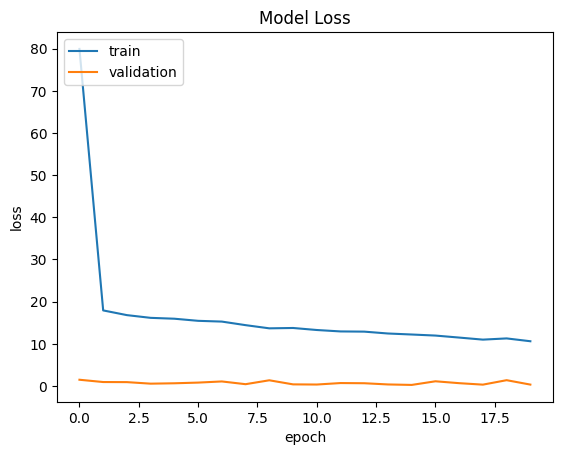

In [406]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [402]:
predicted = model2.predict(x_test)

744/744 [==============================] - 0s 485us/step


In [403]:
loss = model2.evaluate(x_test,y_test)
loss

744/744 [==============================] - 0s 531us/step - loss: 0.3249


0.32486483454704285

In [404]:

a = y_test.flatten()
b = predicted.flatten()
a = list(a)
b = list(b)

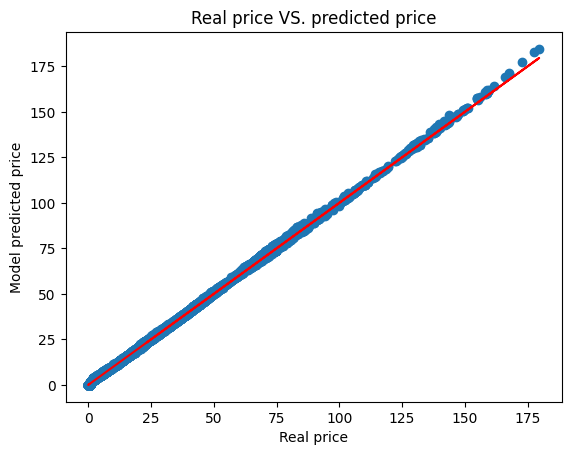

In [405]:
plt.scatter(a, b)
plt.plot(a, f(a),'r-')
plt.title('Real price VS. predicted price')
plt.xlabel('Real price')
plt.ylabel('Model predicted price')
plt.show()

# plt.plot(a, label='actual')
# plt.plot(b, label='predicted')

# plt.xlabel('observation')
# plt.ylabel('option value')

# plt.legend()
# plt.show()

In [386]:
diff = {}
for i,pred in enumerate(predicted):
    diff[i]=abs(pred-y_test[i])
diff = zip(diff.values(),diff.keys())
top10 = sorted(diff)[:20]
for item in top10:
    ind = item[1]
    print("Real Market Price is: {}".format(y_test[ind]))
    print("Model Predicted Price is: {}".format(predicted[ind]))
    print("\n")

Real Market Price is: [29.32914911]
Model Predicted Price is: [29.329176]


Real Market Price is: [37.58056998]
Model Predicted Price is: [37.580536]


Real Market Price is: [15.83983951]
Model Predicted Price is: [15.839769]


Real Market Price is: [19.72738048]
Model Predicted Price is: [19.727587]


Real Market Price is: [58.61943693]
Model Predicted Price is: [58.61918]


Real Market Price is: [17.46886351]
Model Predicted Price is: [17.469128]


Real Market Price is: [18.67998761]
Model Predicted Price is: [18.679596]


Real Market Price is: [15.74300371]
Model Predicted Price is: [15.743413]


Real Market Price is: [37.45299498]
Model Predicted Price is: [37.45253]


Real Market Price is: [19.41909703]
Model Predicted Price is: [19.419598]


Real Market Price is: [15.28728264]
Model Predicted Price is: [15.286604]


Real Market Price is: [34.9931641]
Model Predicted Price is: [34.99386]


Real Market Price is: [32.59655744]
Model Predicted Price is: [32.597374]


Real Market Pric

In [387]:
diff = {}
for i,pred in enumerate(predicted):
    diff[i]=abs(pred-y_test[i])
diff = zip(diff.values(),diff.keys())
worst10 = sorted(diff,reverse=True)[:10]
print("Worst 10 matches\n")
for item in worst10:
    ind = item[1]
    print("Real Market Price is: {}".format(y_test[ind]))
    print("Model Predicted Price is: {}\n".format(predicted[ind]))

Worst 10 matches

Real Market Price is: [177.65741633]
Model Predicted Price is: [186.88184]

Real Market Price is: [179.58507083]
Model Predicted Price is: [188.5869]

Real Market Price is: [172.93077486]
Model Predicted Price is: [181.28943]

Real Market Price is: [167.61072757]
Model Predicted Price is: [175.14236]

Real Market Price is: [167.72660955]
Model Predicted Price is: [174.7102]

Real Market Price is: [165.84072396]
Model Predicted Price is: [172.5849]

Real Market Price is: [158.95169289]
Model Predicted Price is: [165.65623]

Real Market Price is: [154.8677136]
Model Predicted Price is: [161.1446]

Real Market Price is: [161.59787745]
Model Predicted Price is: [167.84642]

Real Market Price is: [159.47725968]
Model Predicted Price is: [165.71596]

